# Project Bankruptcy
## Group members：
| NO  |NAME| 
|-----|----|
|  1  |Divya Khanolkar| 
|  2  |Chi Wen Lee|
|  3  |Yunhan Chiu|
|  4  |Adithya Narayan|
|  5  |Max Szurglies|
|  6  |Rodrigo Ferreyros|

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# models
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Lasso, LassoCV, LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# data resampling
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, NearMiss
from sklearn.ensemble import (
    GradientBoostingRegressor,
    RandomForestClassifier,
    RandomForestRegressor,
    AdaBoostClassifier,
    GradientBoostingClassifier,
)

# feature selection
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import (
    RFE,
    SelectKBest,
    VarianceThreshold,
    mutual_info_classif,
)

# model evaluation
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    auc,
    confusion_matrix,
    f1_score,
    roc_curve,
    roc_auc_score,
)

# hyper parameter tuning
from sklearn.model_selection import GridSearchCV

## Data Loading and process
- load data and check population size
- split data to train and test data

### Load data and check population size
- df: original data
- df_rename: 'Bankrupt?' : 'target', features: Attr1~Attr95

In [2]:
# read in dataset
df = pd.read_csv("data.csv")
df_rename = df.copy()
population_size = len(df)
# rename columns
df.rename(columns={"Bankrupt?": "target"}, inplace=True)
index = 0
for col in df_rename.columns:
    if col == "Bankrupt?":
        df_rename.rename(columns={col: "target"}, inplace=True)
    else:
        df_rename.rename(columns={col: "Attr" + str(index)}, inplace=True)
    index += 1

# checking data population
print("data shape:", df_rename.shape)
# checking target incidence
print("\ndata incidence", df_rename.target.value_counts(normalize=True))


data shape: (6819, 96)

data incidence 0    0.967737
1    0.032263
Name: target, dtype: float64


$\implies$ 3% of target '1': imbalanced data</br>
$\implies$ 96 features: high-dimensional dataset


array([[<AxesSubplot:title={'center':'target'}>,
        <AxesSubplot:title={'center':'Attr1'}>,
        <AxesSubplot:title={'center':'Attr2'}>,
        <AxesSubplot:title={'center':'Attr3'}>,
        <AxesSubplot:title={'center':'Attr4'}>,
        <AxesSubplot:title={'center':'Attr5'}>,
        <AxesSubplot:title={'center':'Attr6'}>,
        <AxesSubplot:title={'center':'Attr7'}>,
        <AxesSubplot:title={'center':'Attr8'}>,
        <AxesSubplot:title={'center':'Attr9'}>],
       [<AxesSubplot:title={'center':'Attr10'}>,
        <AxesSubplot:title={'center':'Attr11'}>,
        <AxesSubplot:title={'center':'Attr12'}>,
        <AxesSubplot:title={'center':'Attr13'}>,
        <AxesSubplot:title={'center':'Attr14'}>,
        <AxesSubplot:title={'center':'Attr15'}>,
        <AxesSubplot:title={'center':'Attr16'}>,
        <AxesSubplot:title={'center':'Attr17'}>,
        <AxesSubplot:title={'center':'Attr18'}>,
        <AxesSubplot:title={'center':'Attr19'}>],
       [<AxesSubplot:title=

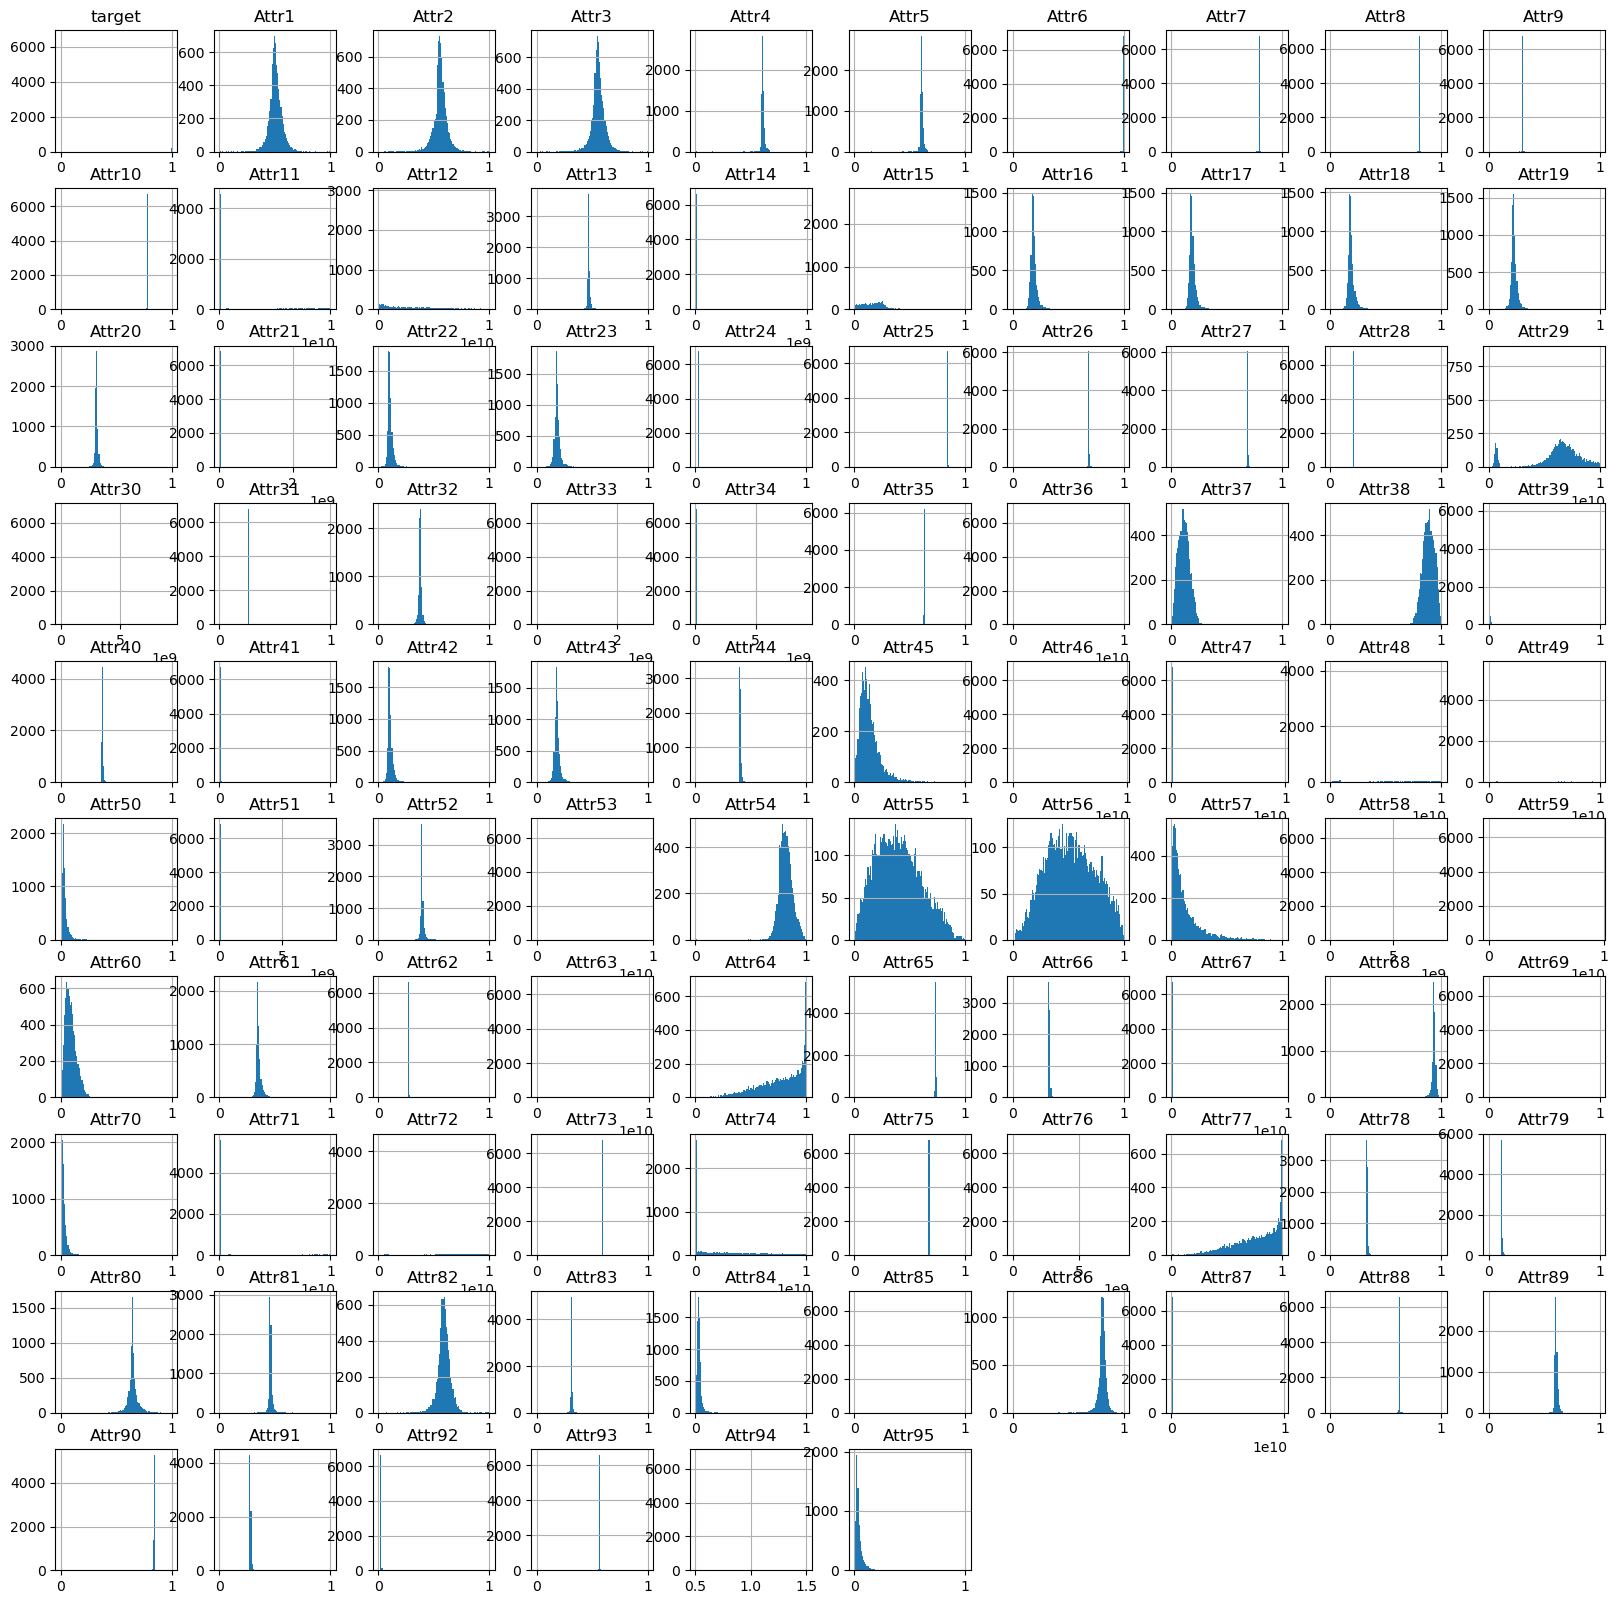

In [3]:
# check the variance of the features
df_rename.hist(bins=100, figsize=(20, 20))

our features have similar range (most of them are 0 to 1)

### Split data to train and test data
- X: all features data
- y: target data
- X_train, X_test, y_train, y_teat splited by 'train_test_split' with test-size 0.3

In [4]:
# assign Data to X and y
X = df_rename.drop(columns="target")
y = df_rename.target

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)
print("X_train shape:", X_train.shape,
      "\nX_test shape:", X_test.shape,
      "\ny_train shape:", y_train.shape,
      "\ny_test shape:", y_test.shape,
     )

X_train shape: (4773, 95) 
X_test shape: (2046, 95) 
y_train shape: (4773,) 
y_test shape: (2046,)


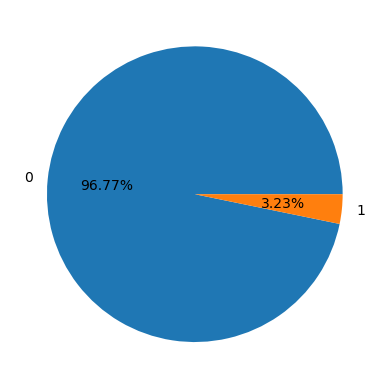

In [6]:
data = df["target"].value_counts()
plt.pie(data, autopct="%1.2f%%", labels=data.index)
plt.show()

## Check overfitting by learning depths
- RandomForest Classifier
- KNeighbors Classifier 
- Decision Tree Classifier</br>
Note that we use accuracy comparision between train and test data for the Logistic Regression to check overfitting problem. </br>
However, the accuracy comparision of other three models above is hard to indentify overfitting. </br>
Therefore, we check overfitting problem for these three models by learning depths </br>

In [7]:
def check_overfitting(X_train, y_train, X_test, y_test, max_depth):
    
    title_name = ["RandomForestClassifier", 
                  "KNeighborsClassifier", 
                  "DecisionTreeClassifier", 
                  "AdaBoostClassifier",
                  "GradientBoostingClassifier",
                 ]
    # random forest: n_estimators, knn: n_estimators, decision tree: max_depth
    models = [RandomForestClassifier(), 
              KNeighborsClassifier(), 
              DecisionTreeClassifier(), 
              AdaBoostClassifier(),
              GradientBoostingClassifier(),
             ]
    
    # plot figure
    fig, sub_figs = plt.subplots(1, 5, sharex=False, figsize=(15, 5), dpi=72)
    # evaluate a decision tree for each depth

    depths = [i for i in range(1, max_depth)]
    for i, model in enumerate(models):

        # define lists to collect scores
        train_acc_scores, test_f1_scores = list(), list()

        for count in depths:
            if type(model) == type(RandomForestClassifier()):
                model == RandomForestClassifier(n_estimators=count)
            elif type(model) == type(KNeighborsClassifier()):
                model = KNeighborsClassifier(n_neighbors=count)
            elif type(model) == type(DecisionTreeClassifier()):
                model = DecisionTreeClassifier(max_depth=count)
            elif type(model) == type(AdaBoostClassifier()):
                model = AdaBoostClassifier(n_estimators=count)
            elif type(model) == type(GradientBoostingClassifier()):
                model = GradientBoostingClassifier(n_estimators=count)
            else:
                print("unhandled model")
                break
            
            # fit model on the training dataset
            model.fit(X_train, y_train)
            
            # evaluate on the train dataset
            train_predict = model.predict(X_train)
            train_acc = accuracy_score(y_train, train_predict)
            train_acc_scores.append(train_acc)
            
            # evaluate on the test dataset
            test_predict = model.predict(X_test)
            test_acc = accuracy_score(y_test, test_predict)
            test_f1_scores.append(test_acc)
        
        # plot of train and test scores vs tree depth
        sub_figs[i].set_title(title_name[i])
        sub_figs[i].plot(depths, train_acc_scores, "-o", label="Train")
        sub_figs[i].plot(depths, test_f1_scores, "-o", label="Test")
        sub_figs[i].legend()
    fig

## Resample Imbalanced data
- Using imblearn library </br>
  1. Undersampling: </br>This technique eliminates or deletes the data points of the majority class to make an equal ratio of major and minor classes.There is a various method for undersampling like Tomek’s links, EditedNearestNeighbours, CondensedNearestNeighbour, InstanceHardnessThreshold, etc.
  2. Oversampling: </br>This technique redistributes randomly the minority class data points to increase the ratio in the dataset.It duplicates the existing data points of minority class and equalizes the ratio of majority and minority class.
  3. SMOTE (Synthetic Minority Oversampling Technique):</br>SMOTE selects the data points of the minority class in feature space to draw a line between those points and generate new points along with the line. Thus this technique synthesizes new data points for minority class and oversample that class.

In [8]:
# Find the best resampled dataset
models = [RandomForestClassifier(), 
          LogisticRegression(solver="liblinear"), 
          KNeighborsClassifier(), 
          DecisionTreeClassifier(), 
          AdaBoostClassifier(),
          GradientBoostingClassifier()
         ]
models_name = ["RandomForestClassifier", 
               "LogisticRegression", 
               "KNeighborsClassifier", 
               "DecisionTreeClassifier", 
               "AdaBoostClassifier",
               "GradientBoostingClassifier"
              ]
# note: Logistic regression failed to converge in most cases with lbfgs algorithm, so we change to liblinear

# claim resample constants
C_ORIGINAL = "Original"
C_UNDERSAMPLING = "UnderSampling"
C_OVERSAMPLING = "OverSampling"
C_SMOTE = "SMOTE"
C_TOMEKLINKS = "TomekLinks" 
C_NEARMISS = "NearMiss"

# claim extraction constants
C_PCA = "PCA"

# claim feature selection constants
C_TARGETHIGHCORR = "TargetHighCorr"
C_REMOVE5VIF = "remove5VIF with targetHighCorr"
C_MODELREDUCEFEATURE = "ModelReduceFeature"
C_KBESTMUTUALINFO = "kBestMutualInfo"
C_OPT = "tuneHyperparameter"

# model data init
data_names = [C_ORIGINAL, C_UNDERSAMPLING, C_OVERSAMPLING, C_SMOTE, C_TOMEKLINKS, C_NEARMISS]
models_f1Score = pd.DataFrame(columns=models_name, index=data_names)
models_accurracy = pd.DataFrame(columns=models_name, index=data_names)

# for later combined charts
auc_rocs = {}

In [9]:
def update_aucs(md_name, data_name, auc_val):
    if not auc_rocs or data_name not in auc_rocs:
        auc_rocs[data_name] = []
        auc_rocs[data_name].append(auc_val)

    exist = False
    # exist replace
    for i, data in enumerate(auc_rocs[data_name]):
        if data['model_name'] == md_name:
            data = auc_val
            exist = True
            break
    # not exist append
    if not exist:
        auc_rocs[data_name].append(auc_val)

In [10]:
def print_roc_auc_curve_cm(y_test, y_pre, probabilities, md_name, data_name):
    # select the probabilities for label 1.0
    y_proba = probabilities[:, 1]

    # calculate false positive rate and true positive rate at different thresholds
    false_positive_rate, true_positive_rate, thresholds = roc_curve(
        y_test, y_proba, pos_label=1
    )
    
    # calculate AUC
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    # save combined data to global variables
    auc_val = {"model_name": md_name, "auc": roc_auc, "fpr": false_positive_rate, "tpr": true_positive_rate}
    update_aucs(md_name, data_name, auc_val)

    # create plot
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(12, 4), dpi=72)
    plot_title = (
            md_name
            + "("
            + data_name
            + ") F1s:"
            + format(models_f1Score[md_name][data_name], ".2f")
        )

    ax1.set_title(plot_title)
    # plot the false positive rate on the x axis and the true positive rate on the y axis
    roc_plot = ax1.plot(
        false_positive_rate, true_positive_rate, label="AUC = {:0.2f}".format(roc_auc)
    )
    ax1.legend(loc=0)
    ax1.plot([0, 1], [0, 1], ls="--")
    ax1.set_ylabel("True Positive Rate")
    ax1.set_xlabel("False Positive Rate")

    # print confusion matrix
    c_matrix = confusion_matrix(y_test, y_pre)
    ax2.set_title(plot_title)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=c_matrix, display_labels=["Not bankrupt", "Is bankrupt"]
    )
    disp.plot(ax=ax2)
    fig

In [11]:
def get_f1score_accuracy(y_test, y_pre):
    return f1_score(y_test, y_pre, average="macro"), accuracy_score(y_test, y_pre)

In [12]:
def testModels(X_train, y_train, X_test, y_test, data_name, needPrint):
    # init model f1 and accuracy
    models_f1Score.loc[data_name] = np.zeros(len(models))
    models_accurracy.loc[data_name] = np.zeros(len(models))
    
    for md_name, md in zip(models_name, models):
        # predict
        md.fit(X_train, y_train)
        y_pre = md.predict(X_test)
        probabilities = md.predict_proba(X_test)
        
        # get f1 score and accuracy
        models_f1Score.loc[data_name,md_name], models_accurracy.loc[data_name,md_name] = get_f1score_accuracy(y_test, y_pre)
    
        if needPrint:
            # print roc curve and confusion matrix
            print_roc_auc_curve_cm(y_test, y_pre, probabilities, md_name, data_name)
        #overfitting check
        train_pre = md.predict(X_train)
        train_acc = accuracy_score(y_train, train_pre)
        print(md_name+": train accurancy-",format(train_acc,".2f"),
              "and test accruancy-",format(models_accurracy[md_name][data_name],".2f")
             )    

In [13]:
testModels(X_train, y_train, X_test, y_test, C_ORIGINAL, False)

RandomForestClassifier: train accurancy- 1.00 and test accruancy- 0.97
LogisticRegression: train accurancy- 0.97 and test accruancy- 0.97
KNeighborsClassifier: train accurancy- 0.97 and test accruancy- 0.97
DecisionTreeClassifier: train accurancy- 1.00 and test accruancy- 0.95
AdaBoostClassifier: train accurancy- 0.98 and test accruancy- 0.96
GradientBoostingClassifier: train accurancy- 0.99 and test accruancy- 0.97


In [14]:
# Undersampling
rus = RandomUnderSampler(random_state=0)
X_underSampling, y_underSampling = rus.fit_resample(X_train, y_train)
print(
    "X_underSampling's shape:",
    X_underSampling.shape,
    "y_underSampling's shape:",
    y_underSampling.shape,
)
print("y_underSampling:\n", y_underSampling.value_counts(normalize=True))
testModels(X_underSampling, y_underSampling, X_test, y_test, C_UNDERSAMPLING, False)


X_underSampling's shape: (308, 95) y_underSampling's shape: (308,)
y_underSampling:
 0    0.5
1    0.5
Name: target, dtype: float64
RandomForestClassifier: train accurancy- 1.00 and test accruancy- 0.86
LogisticRegression: train accurancy- 0.61 and test accruancy- 0.69
KNeighborsClassifier: train accurancy- 0.76 and test accruancy- 0.57
DecisionTreeClassifier: train accurancy- 1.00 and test accruancy- 0.80
AdaBoostClassifier: train accurancy- 1.00 and test accruancy- 0.85
GradientBoostingClassifier: train accurancy- 1.00 and test accruancy- 0.86


In [15]:
# TomekLinks
tl = TomekLinks(sampling_strategy = 'majority')
# fit predictor and target variable
X_TomekLinks, y_TomekLinks = tl.fit_resample(X_train, y_train)
testModels(X_TomekLinks, y_TomekLinks, X_test, y_test, C_TOMEKLINKS, False)

RandomForestClassifier: train accurancy- 1.00 and test accruancy- 0.97
LogisticRegression: train accurancy- 0.97 and test accruancy- 0.97
KNeighborsClassifier: train accurancy- 0.97 and test accruancy- 0.97
DecisionTreeClassifier: train accurancy- 1.00 and test accruancy- 0.95
AdaBoostClassifier: train accurancy- 0.98 and test accruancy- 0.96
GradientBoostingClassifier: train accurancy- 1.00 and test accruancy- 0.96


In [16]:
# NearMiss
nm = NearMiss(sampling_strategy = 'majority')
# fit predictor and target variable
X_NearMiss, y_NearMiss = nm.fit_resample(X_train, y_train)
testModels(X_NearMiss, y_NearMiss, X_test, y_test, C_NEARMISS, False)

RandomForestClassifier: train accurancy- 1.00 and test accruancy- 0.61
LogisticRegression: train accurancy- 0.97 and test accruancy- 0.10
KNeighborsClassifier: train accurancy- 0.95 and test accruancy- 0.12
DecisionTreeClassifier: train accurancy- 1.00 and test accruancy- 0.39
AdaBoostClassifier: train accurancy- 1.00 and test accruancy- 0.24
GradientBoostingClassifier: train accurancy- 1.00 and test accruancy- 0.33


In [17]:
# Oversampling
ros = RandomOverSampler(random_state=0)
X_overSampling, y_overSampling = ros.fit_resample(X_train, y_train)
print(
    "X_overSampling's shape:",
    X_overSampling.shape,
    "y_overSampling's shape:",
    y_overSampling.shape,
)
print("y_overSampling:\n", y_overSampling.value_counts(normalize=True))
testModels(X_overSampling, y_overSampling, X_test, y_test, C_OVERSAMPLING, False)

X_overSampling's shape: (9238, 95) y_overSampling's shape: (9238,)
y_overSampling:
 0    0.5
1    0.5
Name: target, dtype: float64
RandomForestClassifier: train accurancy- 1.00 and test accruancy- 0.97
LogisticRegression: train accurancy- 0.61 and test accruancy- 0.74
KNeighborsClassifier: train accurancy- 0.97 and test accruancy- 0.91
DecisionTreeClassifier: train accurancy- 1.00 and test accruancy- 0.95
AdaBoostClassifier: train accurancy- 0.96 and test accruancy- 0.92
GradientBoostingClassifier: train accurancy- 0.98 and test accruancy- 0.93


In [18]:
# SMOTE
sm = SMOTE(random_state=0)
X_smote, y_smote = sm.fit_resample(X_train, y_train)
print("X_smote's shape:", X_smote.shape, "y_smote's shape:", y_smote.shape)
print("y_smote:\n", y_smote.value_counts(normalize=True))
testModels(X_smote, y_smote, X_test, y_test, C_SMOTE, False)

X_smote's shape: (9238, 95) y_smote's shape: (9238,)
y_smote:
 0    0.5
1    0.5
Name: target, dtype: float64
RandomForestClassifier: train accurancy- 1.00 and test accruancy- 0.96
LogisticRegression: train accurancy- 0.58 and test accruancy- 0.75
KNeighborsClassifier: train accurancy- 0.95 and test accruancy- 0.85
DecisionTreeClassifier: train accurancy- 1.00 and test accruancy- 0.93
AdaBoostClassifier: train accurancy- 0.96 and test accruancy- 0.93
GradientBoostingClassifier: train accurancy- 0.98 and test accruancy- 0.94


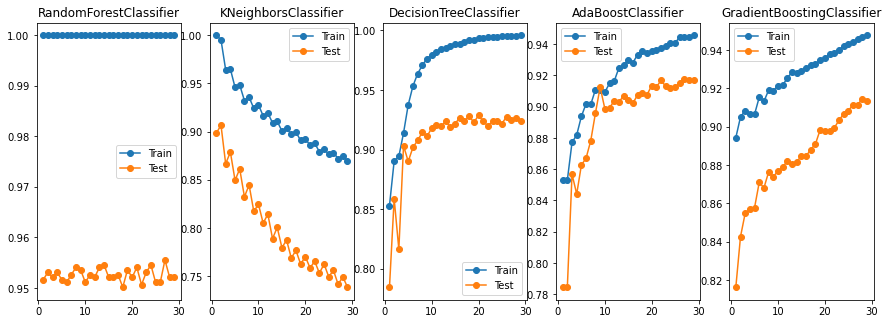

In [19]:
check_overfitting(X_smote, y_smote, X_test, y_test, 30)

In [20]:
models_f1Score

,RandomForestClassifier,LogisticRegression,KNeighborsClassifier,DecisionTreeClassifier,AdaBoostClassifier,GradientBoostingClassifier
Original,0.636448,0.491298,0.519838,0.635638,0.661255,0.64644
UnderSampling,0.602032,0.459332,0.39462,0.545171,0.576269,0.593734
OverSampling,0.632524,0.480752,0.547065,0.581142,0.644236,0.676387
SMOTE,0.694895,0.482676,0.530957,0.634439,0.651643,0.683456
TomekLinks,0.655003,0.491171,0.519838,0.640113,0.643657,0.631414
NearMiss,0.440366,0.100421,0.113501,0.313968,0.213732,0.279441


In [21]:
models_accurracy

,RandomForestClassifier,LogisticRegression,KNeighborsClassifier,DecisionTreeClassifier,AdaBoostClassifier,GradientBoostingClassifier
Original,0.968719,0.965787,0.967253,0.947214,0.962366,0.965298
UnderSampling,0.856794,0.691593,0.565494,0.79521,0.84653,0.859238
OverSampling,0.965298,0.740469,0.906647,0.953079,0.915934,0.934995
SMOTE,0.955523,0.746823,0.849462,0.92913,0.926686,0.94086
TomekLinks,0.967742,0.965298,0.967253,0.951124,0.960411,0.960411
NearMiss,0.605083,0.101662,0.115836,0.387097,0.237537,0.332845


## Penalize Algorithms (Cost-Sensitive Training)

In [22]:
from sklearn.svm import SVC

# we can add class_weight='balanced' to add panalize mistake
svc_model = SVC(class_weight='balanced', probability=True)

svc_model.fit(X_train, y_train)

svc_predict = svc_model.predict(X_test)# check performance
print('ROCAUC score:',roc_auc_score(y_test, svc_predict))
print('Accuracy score:',accuracy_score(y_test, svc_predict))
print('F1 score:',f1_score(y_test, svc_predict))

ROCAUC score: 0.6214646464646465
Accuracy score: 0.7209188660801564
F1 score: 0.10641627543035993


## Feature Extraction by PCA
PCA is a dimensionality reduction technique that has four main parts: feature covariance, eigendecomposition, principal component transformation, and choosing components in terms of explained variance.

### Scale training and test features

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# define standard scaler
ss = StandardScaler()

# fit the scaler and transform the training features
X_train_stand = ss.fit_transform(X_train)

# transform the test features
X_test_stand = ss.transform(X_test)

### Perform PCA

In [24]:
# instantiate a PCA object with 10 components
pca = PCA(n_components = 10)

# use fit_transform on our standardized training features
X_train_PCA = pca.fit_transform(X_train_stand)

# use transform on our standardized test features
X_test_PCA = pca.transform(X_test_stand)

In [25]:
testModels(X_train_PCA, y_train, X_test_PCA, y_test, C_PCA, False)

RandomForestClassifier: train accurancy- 1.00 and test accruancy- 0.97
LogisticRegression: train accurancy- 0.97 and test accruancy- 0.97
KNeighborsClassifier: train accurancy- 0.97 and test accruancy- 0.97
DecisionTreeClassifier: train accurancy- 1.00 and test accruancy- 0.95
AdaBoostClassifier: train accurancy- 0.97 and test accruancy- 0.96
GradientBoostingClassifier: train accurancy- 0.98 and test accruancy- 0.97


## According to the above result, SMOTE has best accuracy, so we will continue to select features using oversampling data.

In [26]:
X_resample = X_smote.copy()
y_resample = y_smote.copy()
X_resample.shape, y_resample.shape

((9238, 95), (9238,))

In [27]:
X_resample.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr86,Attr87,Attr88,Attr89,Attr90,Attr91,Attr92,Attr93,Attr94,Attr95
0,0.577634,0.650131,0.640987,0.613111,0.613111,0.999168,0.797648,0.809559,0.303561,0.781834,...,0.846247,0.001604,0.625023,0.613105,0.845538,0.283816,0.026811,0.565250,1,0.020829
1,0.507093,0.565907,0.553188,0.601551,0.601551,0.999023,0.797465,0.809365,0.303544,0.781620,...,0.813017,0.001934,0.623323,0.601547,0.841623,0.281430,0.027045,0.566135,1,0.024576
2,0.489056,0.521969,0.543926,0.596340,0.596340,0.998941,0.797357,0.809285,0.303526,0.781539,...,0.789707,0.009648,0.624593,0.596341,0.839563,0.279088,0.026674,0.564527,1,0.032201
3,0.555648,0.599815,0.594357,0.604217,0.604217,0.999089,0.797528,0.809411,0.303516,0.781677,...,0.830968,0.000908,0.624633,0.604219,0.842402,0.277784,0.026817,0.565280,1,0.041431
4,0.449374,0.515591,0.500616,0.596499,0.596499,0.998937,0.797356,0.809285,0.303533,0.781539,...,0.777253,0.001069,0.623805,0.596497,0.838273,0.281692,0.026386,0.562021,1,0.024040


## Feature Selectioon
- Removing highly correlated features
- Removing highly  VIF-scored features
- Selecting for Model Accuracy
- Selecting by Mutual Information

### Removing highly VIF-scored features

In [28]:
# calculate the correlation between target and each feature and take the absolute value
corr_df = df_rename.corr()["target"].abs()
# list of features which have at least 9% (the mean of total correlations) correlation to the target
features = corr_df[corr_df <= 0.09].index.to_list()[1:]
# drop the features in the features list
train_targetHighCorr = X_resample.drop(features, axis=1)
test_targetHighCorr = X_test.drop(features, axis=1)

In [29]:
# the mean of total correlations
corr_df.mean()

0.09116505557155975

In [30]:
train_targetHighCorr.shape

(9238, 36)

In [31]:
testModels(train_targetHighCorr, y_resample, test_targetHighCorr, y_test, C_TARGETHIGHCORR, False)

RandomForestClassifier: train accurancy- 1.00 and test accruancy- 0.94
LogisticRegression: train accurancy- 0.89 and test accruancy- 0.88
KNeighborsClassifier: train accurancy- 0.96 and test accruancy- 0.88
DecisionTreeClassifier: train accurancy- 1.00 and test accruancy- 0.92
AdaBoostClassifier: train accurancy- 0.93 and test accruancy- 0.89
GradientBoostingClassifier: train accurancy- 0.95 and test accruancy- 0.91


In [32]:
def drop_vif(df, vifIndex):
    vif, tolerance = {}, {}
    # all the features that you want to examine
    for feature in df.columns:
        # extract all the other features you will regress against
        X = [f for f in df.columns if f != feature]
        X, y = df[X], df[feature]
        # extract r-squared from the fit
        r2 = LinearRegression().fit(X, y).score(X, y)
        # calculate tolerance
        tolerance[feature] = 1 - r2
        # calculate VIF
        if tolerance[feature] == 0:
            vif[feature] = 0
            continue
        vif[feature] = 1 / (tolerance[feature])
    # return drop features of VIF > vifIndex
    to_drop = [f for f in df.columns if vif[f] > vifIndex]
    return to_drop

In [33]:
# drop the features whose VIF is greater than 5 after targetHighCorr
train_remove5VIF = train_targetHighCorr.drop(drop_vif(train_targetHighCorr, 5), axis=1)
train_remove5VIF.shape
test_remove5VIF = test_targetHighCorr.drop(drop_vif(train_targetHighCorr, 5), axis=1)

In [34]:
testModels(train_remove5VIF, y_resample, test_remove5VIF, y_test, C_REMOVE5VIF, False)

RandomForestClassifier: train accurancy- 1.00 and test accruancy- 0.92
LogisticRegression: train accurancy- 0.84 and test accruancy- 0.84
KNeighborsClassifier: train accurancy- 0.95 and test accruancy- 0.86
DecisionTreeClassifier: train accurancy- 1.00 and test accruancy- 0.90
AdaBoostClassifier: train accurancy- 0.88 and test accruancy- 0.86
GradientBoostingClassifier: train accurancy- 0.93 and test accruancy- 0.89


### Selecting for Model Accuracy
1. LassoCV
2. GradientBoostingRegressor
3. RandomForestRegressor

we test three regression's accuracy to decide which features to select

#### 1. Using LassoCV() regressor which tunes the regularization strength (alpha) using cross validation

In [35]:
# 1. LassoCV
# create and fit the LassoCV model on the training set
lcv = LassoCV()
lcv.fit(X_resample, y_resample)
optimal_alpha = float("{:.3f}".format(lcv.alpha_))
print(f"Optimal alpha = {optimal_alpha}")

# calculate R squared on the test set
r_squared = lcv.score(X_test, y_test)
print(f"The model explains {r_squared:.1%} of the test set variance")

# create a mask for coefficients not equal to zero
lcv_mask = lcv.coef_ != 0
print(f"The LassoCV() model select {sum(lcv_mask)} features out of {len(lcv_mask)} selected")


Optimal alpha = 167424.766
The model explains -671.4% of the test set variance
The LassoCV() model select 22 features out of 95 selected


#### 2. Using Recursive Feature Eliminator (RFE) on a GradientBoostingRegressor

In [36]:
# 2. GradientBoostingRegressor
# select 10 features with RFE and drop 19 features on each step
rfe_gb = RFE(
    estimator=GradientBoostingRegressor(), n_features_to_select=10, step=19, verbose=1
)
rfe_gb.fit(X_resample, y_resample)

# calculate the R squared on the test set
r_squared = rfe_gb.score(X_test, y_test)
print(f"The model can explain {r_squared:.1%} of the variance in the test set")

# assign the support array to gb_mask
gb_mask = rfe_gb.support_

Fitting estimator with 95 features.
Fitting estimator with 76 features.
Fitting estimator with 57 features.
Fitting estimator with 38 features.
Fitting estimator with 19 features.
The model can explain -125.2% of the variance in the test set


#### 3. Using RFE on a RandomForestRegressor

In [37]:
# 3. RandomForestRegressor
# select 10 features with RFE on a RandomForestRegressor, drop 19 feature on each step
rfe_rf = RFE(
    estimator=RandomForestRegressor(), n_features_to_select=10, step=19, verbose=1
)
rfe_rf.fit(X_resample, y_resample)

# calculate the R squared on the test set
r_squared = rfe_rf.score(X_test, y_test)
print(f"The model can explain {r_squared:.1%} of the variance in the test set")

# assign the support array to rf_mask
rf_mask = rfe_rf.support_

Fitting estimator with 95 features.
Fitting estimator with 76 features.
Fitting estimator with 57 features.
Fitting estimator with 38 features.
Fitting estimator with 19 features.
The model can explain -39.7% of the variance in the test set


In [38]:
# sum the votes of the three models
votes = np.sum([lcv_mask, gb_mask, rf_mask], axis=0)
print("votes:", votes) # 0: not helpful, 1: only helpful for 1 model ... 3: helpful for all models

# create a mask for features selected by at least 2 model
meta_mask = votes >= 2

# apply the dimensionality reduction on X
train_modelReduceFeature = X_resample.loc[:, meta_mask]
train_modelReduceFeature.shape
test_modelReduceFeature = X_test.loc[:, meta_mask]

votes: [0 0 0 0 0 0 0 0 2 2 1 1 0 3 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 2 1 3 0
 0 0 2 0 0 0 0 0 1 3 1 1 0 1 0 2 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 1 1 0 3
 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 2 0 0 0 0 0]


In [39]:
testModels(train_modelReduceFeature, y_resample, test_modelReduceFeature, y_test, C_MODELREDUCEFEATURE, False)

RandomForestClassifier: train accurancy- 1.00 and test accruancy- 0.94
LogisticRegression: train accurancy- 0.50 and test accruancy- 0.97
KNeighborsClassifier: train accurancy- 0.83 and test accruancy- 0.72
DecisionTreeClassifier: train accurancy- 1.00 and test accruancy- 0.93
AdaBoostClassifier: train accurancy- 0.94 and test accruancy- 0.91
GradientBoostingClassifier: train accurancy- 0.96 and test accruancy- 0.92


### Selecting by Mutual Infromation


The MI score will fall in the range from 0 to ∞. The higher value, the closer connection between this feature and the target, which suggests that we should put this feature in the training dataset.<br>
If the MI score is 0 or very low like 0.01. the low score suggests a weak connection between this feature and the target.

Text(0, 0.5, 'Mutual Information')

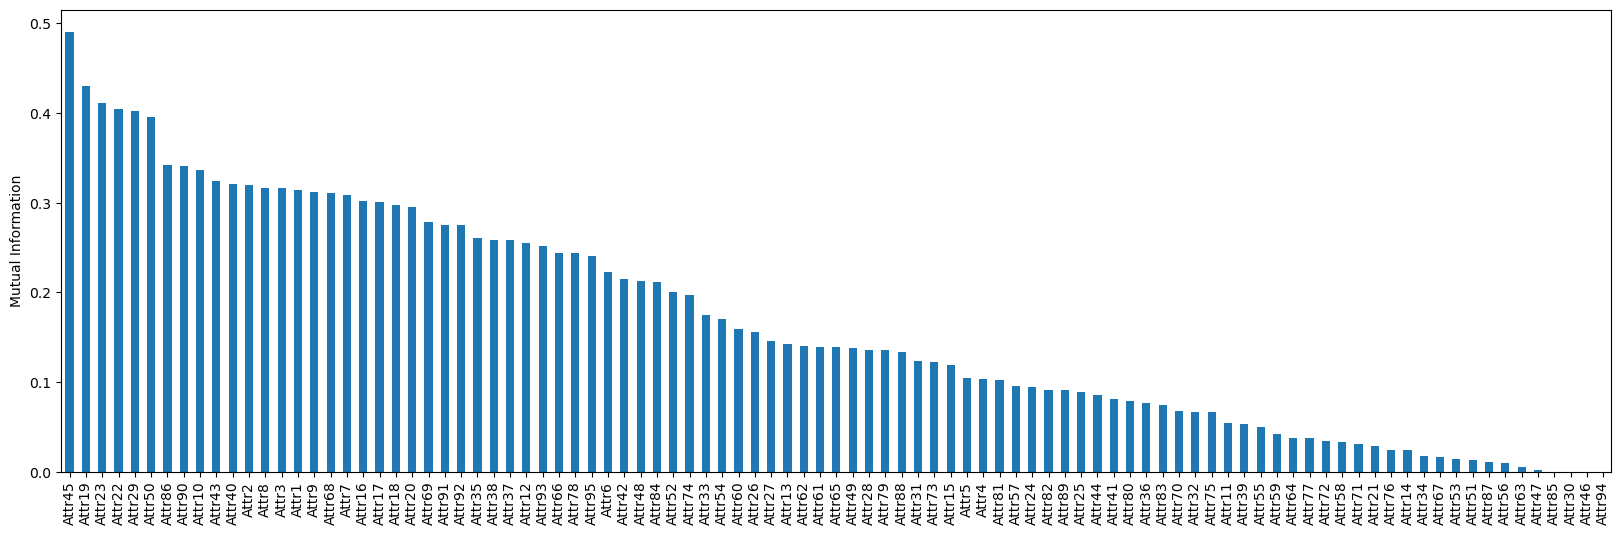

In [40]:
# the less mi value, the less information we can get from
mi = mutual_info_classif(X_resample, y_resample)
miseries = pd.Series(mi)
miseries.index = X_resample.columns
miseries.sort_values(ascending=False).plot.bar(figsize=(20, 6))
plt.ylabel("Mutual Information")


RandomForestClassifier: train accurancy- 1.00 and test accruancy- 0.89
LogisticRegression: train accurancy- 0.50 and test accruancy- 0.97
KNeighborsClassifier: train accurancy- 0.90 and test accruancy- 0.91
DecisionTreeClassifier: train accurancy- 1.00 and test accruancy- 0.87
AdaBoostClassifier: train accurancy- 0.87 and test accruancy- 0.83
GradientBoostingClassifier: train accurancy- 0.90 and test accruancy- 0.86


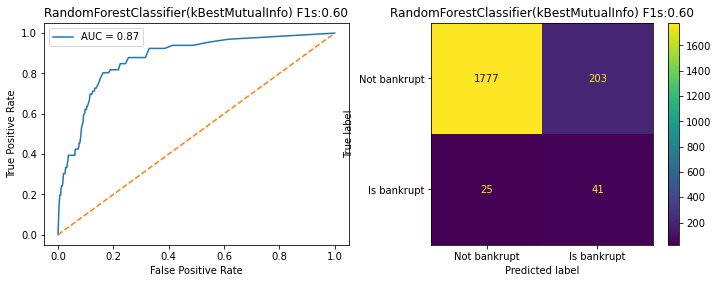

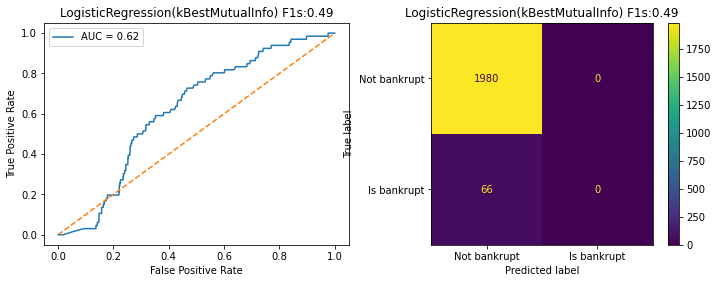

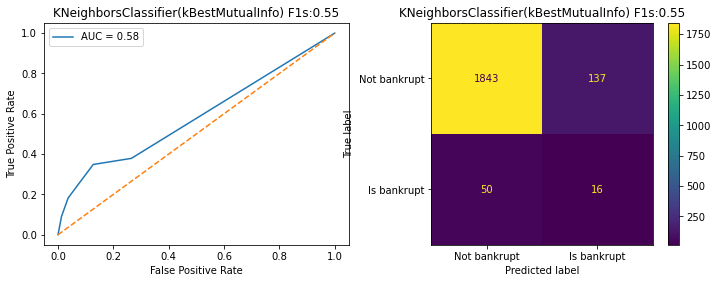

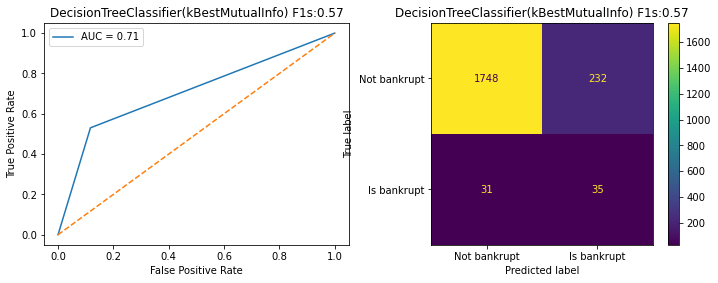

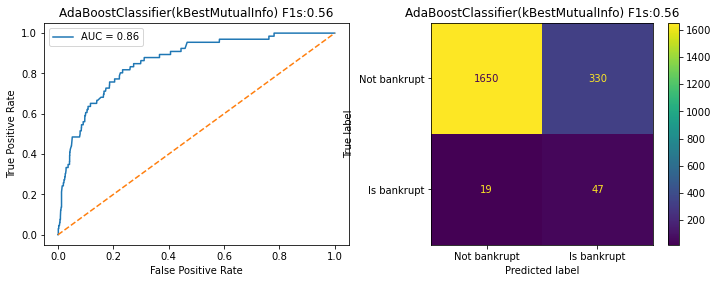

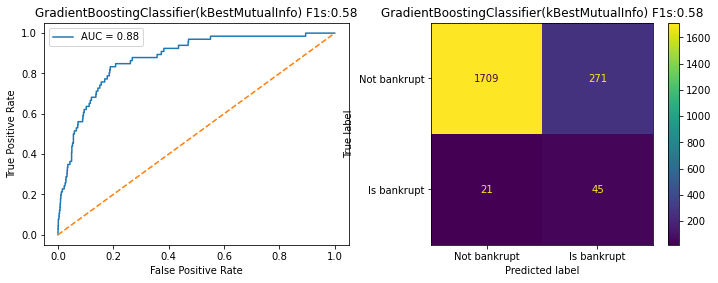

In [41]:
# use optimal_k
k_best = SelectKBest(mutual_info_classif, k=5).fit(X_resample, y_resample)
X_train_kBest = k_best.transform(X_resample)
X_test_kBest = k_best.transform(X_test)
testModels(X_train_kBest, y_resample, X_test_kBest, y_test, C_KBESTMUTUALINFO, False)

In [42]:
models_f1Score

,RandomForestClassifier,LogisticRegression,KNeighborsClassifier,DecisionTreeClassifier,AdaBoostClassifier,GradientBoostingClassifier
Original,0.636448,0.491298,0.519838,0.635638,0.661255,0.64644
UnderSampling,0.602032,0.459332,0.39462,0.545171,0.576269,0.593734
OverSampling,0.632524,0.480752,0.547065,0.581142,0.644236,0.676387
SMOTE,0.694895,0.482676,0.530957,0.634439,0.651643,0.683456
TomekLinks,0.655003,0.491171,0.519838,0.640113,0.643657,0.631414
NearMiss,0.440366,0.100421,0.113501,0.313968,0.213732,0.279441
PCA,0.552878,0.573493,0.602365,0.632535,0.630982,0.617434
TargetHighCorr,0.658299,0.617032,0.601723,0.596488,0.622429,0.643875
remove5VIF with targetHighCorr,0.629211,0.590727,0.575114,0.590349,0.594787,0.628577
ModelReduceFeature,0.684178,0.491551,0.469771,0.622726,0.651893,0.668829


In [43]:
models_accurracy

,RandomForestClassifier,LogisticRegression,KNeighborsClassifier,DecisionTreeClassifier,AdaBoostClassifier,GradientBoostingClassifier
Original,0.968719,0.965787,0.967253,0.947214,0.962366,0.965298
UnderSampling,0.856794,0.691593,0.565494,0.79521,0.84653,0.859238
OverSampling,0.965298,0.740469,0.906647,0.953079,0.915934,0.934995
SMOTE,0.955523,0.746823,0.849462,0.92913,0.926686,0.94086
TomekLinks,0.967742,0.965298,0.967253,0.951124,0.960411,0.960411
NearMiss,0.605083,0.101662,0.115836,0.387097,0.237537,0.332845
PCA,0.965298,0.965298,0.965787,0.952102,0.964809,0.965298
TargetHighCorr,0.936461,0.875855,0.880254,0.917889,0.893939,0.912512
remove5VIF with targetHighCorr,0.922287,0.841642,0.855816,0.895894,0.86217,0.891984
ModelReduceFeature,0.939883,0.966764,0.719453,0.926197,0.911535,0.920332


## According to the above table, we choose k best mutual info as final dataset

RandomForestClassifier: train accurancy- 1.00 and test accruancy- 0.88
LogisticRegression: train accurancy- 0.50 and test accruancy- 0.97
KNeighborsClassifier: train accurancy- 0.90 and test accruancy- 0.91
DecisionTreeClassifier: train accurancy- 1.00 and test accruancy- 0.87
AdaBoostClassifier: train accurancy- 0.87 and test accruancy- 0.83
GradientBoostingClassifier: train accurancy- 0.90 and test accruancy- 0.86


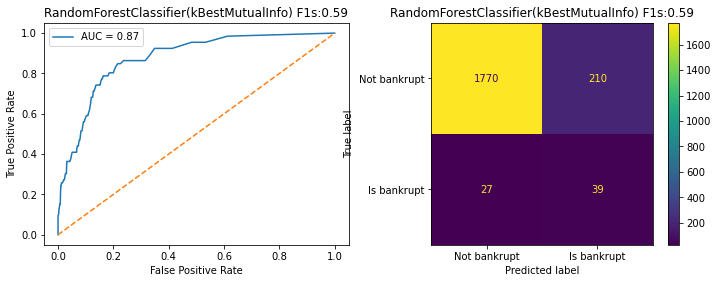

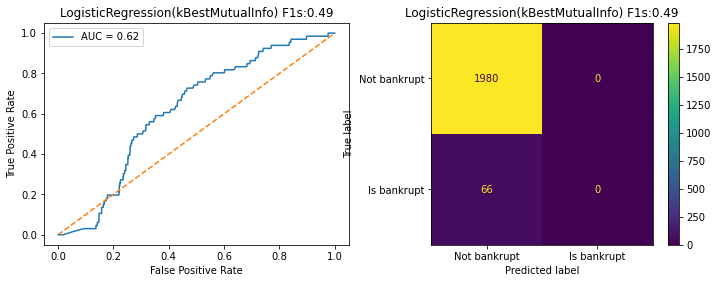

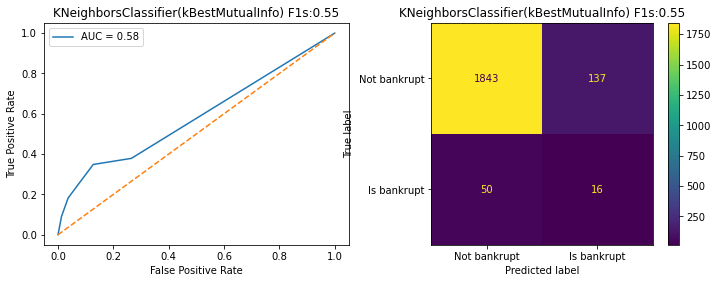

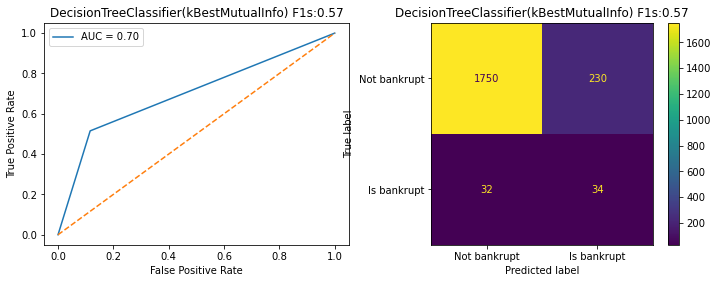

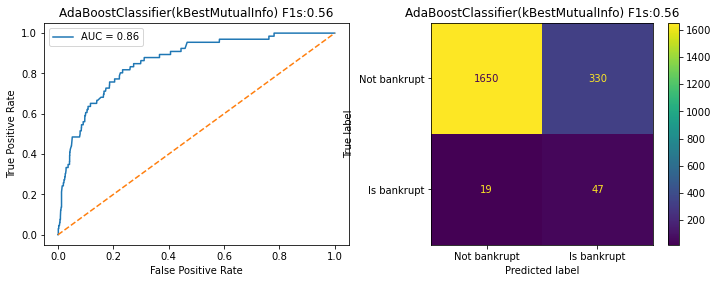

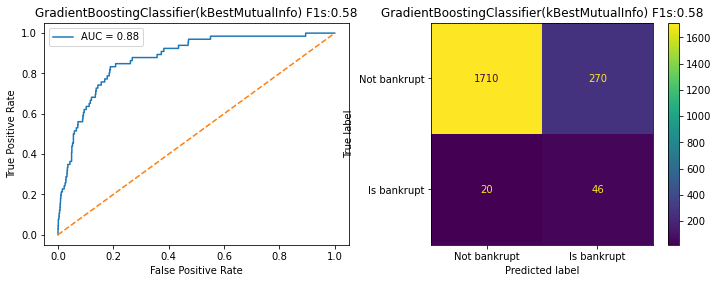

In [44]:
X_train_final = X_train_kBest.copy()
X_test_final = X_test_kBest.copy()

X_train_final.shape, X_test_final.shape

testModels(X_train_final, y_resample, X_test_final, y_test, C_KBESTMUTUALINFO, True)

we find out that "random forest" results in overfitting problem.

## Model Selection

### Test models with hyperparameters and compare them with default hyperparameters

Using "grid search" package for hyperparameter tuning

The point of the grid that maximizes the average value in cross-validation, is the optimal combination of values for the hyperparameters.

We do not use random search because it tests only a randomly selected subset of these points. Besides, the smaller this subset, the faster but less accurate the optimization.

In [45]:
model_params = {
    "knn": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [
                1,
                3,
                5,
                7,
                15,
                17,
                100,
            ],  # odd number, how many neighbors we use to decide the best classfication result
            "p": [1, 2, 5],  # power parameter for the Minkowski metric
        },
    },
    "random_forest": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [
                1,
                5,
                7,
                10,
                44,
                50,
                60,
            ],  # the number of trees in the forest
        },
    },
    "logistic_regression": {
        "model": LogisticRegression(solver="liblinear"),
        "params": {
            "C": [
                1,
                5,
                9,
                10,
            ],  # inverse of regularization strength; must be a positive float
        },
    },
    "decision_tree": {
        "model": DecisionTreeClassifier(),
        "params": {
            "max_depth": [10,20,30,40]
        }       
    },
    "ada_boost": {
        "model": AdaBoostClassifier(),
        "params": {
            "n_estimators": [
                1,
                5,
                7,
                10,
                44,
                50,
                60,
            ],  # the number of trees in the forest
        },
    },
    "gradient_boosting": {
        "model": GradientBoostingClassifier(),
        "params": {
            "n_estimators": [
                1,
                5,
                7,
                10,
                44,
                50,
                60,
            ],  # the number of trees in the forest
        },
    },
}

In [46]:
# to find the best hyperparameters
scores = []
for model_name, mp in model_params.items():
    clf = GridSearchCV(mp["model"], mp["params"], cv=5, return_train_score=False)
    clf.fit(X_train_final, y_resample)
    scores.append(
        {
            "model": model_name,
            "best_score": clf.best_score_,
            "best_params": clf.best_params_,
        }
    )

df = pd.DataFrame(scores, columns=["model", "best_score", "best_params"])
df

,model,best_score,best_params
0,knn,0.896083,"{'n_neighbors': 1, 'p': 2}"
1,random_forest,0.922386,{'n_estimators': 44}
2,logistic_regression,0.499892,{'C': 1}
3,decision_tree,0.892294,{'max_depth': 10}
4,ada_boost,0.871617,{'n_estimators': 60}
5,gradient_boosting,0.883416,{'n_estimators': 60}


RandomForestClassifier: train accurancy- 1.00 and test accruancy- 0.89
LogisticRegression: train accurancy- 0.50 and test accruancy- 0.97
KNeighborsClassifier: train accurancy- 1.00 and test accruancy- 0.92
DecisionTreeClassifier: train accurancy- 0.94 and test accruancy- 0.85
AdaBoostClassifier: train accurancy- 0.87 and test accruancy- 0.83
GradientBoostingClassifier: train accurancy- 0.89 and test accruancy- 0.86


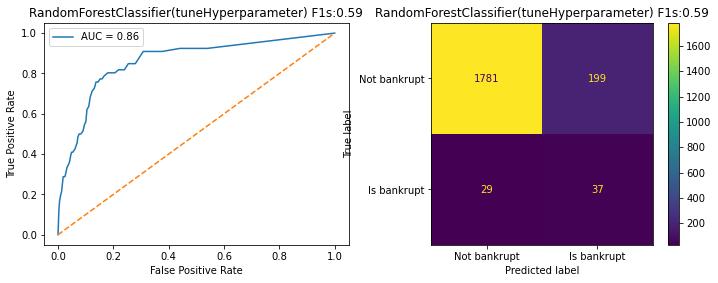

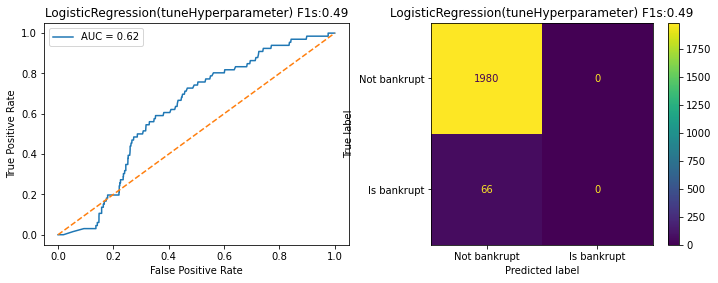

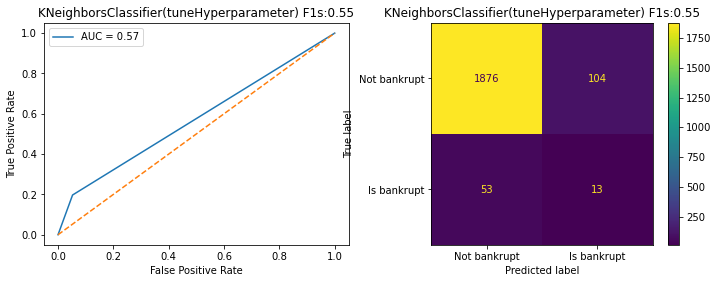

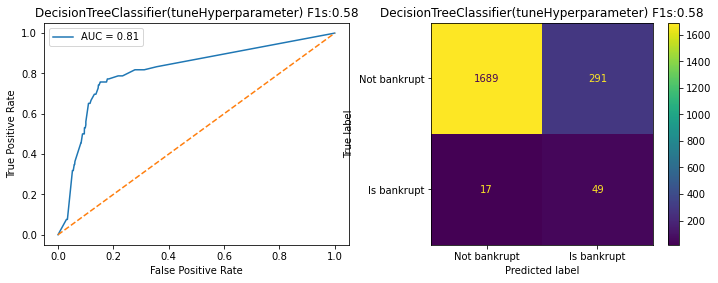

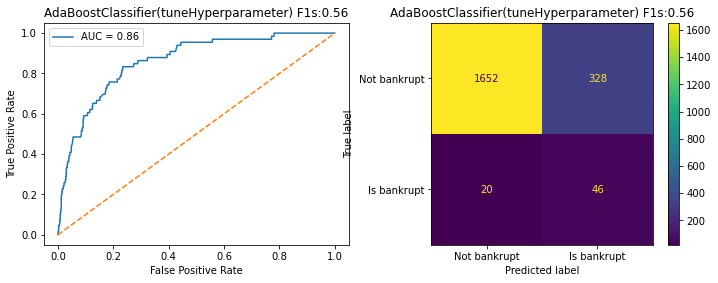

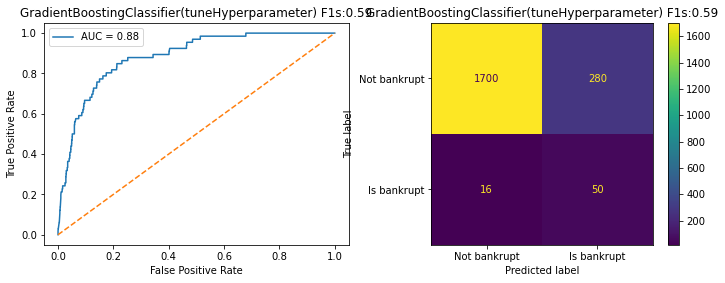

In [49]:
# display optimal solutions
optimal_models = [RandomForestClassifier(n_estimators=44), 
                  LogisticRegression(solver="liblinear", C=1), 
                  KNeighborsClassifier(n_neighbors=1, p=2), 
                  DecisionTreeClassifier(max_depth=10),
                  AdaBoostClassifier(n_estimators=60),
                  GradientBoostingClassifier(n_estimators=60),
                 ]
models = optimal_models
testModels(X_train_final, y_resample, X_test_final, y_test, C_OPT, True)

## Model Evaluation

In [50]:
models_f1Score

,RandomForestClassifier,LogisticRegression,KNeighborsClassifier,DecisionTreeClassifier,AdaBoostClassifier,GradientBoostingClassifier
Original,0.636448,0.491298,0.519838,0.635638,0.661255,0.64644
UnderSampling,0.602032,0.459332,0.39462,0.545171,0.576269,0.593734
OverSampling,0.632524,0.480752,0.547065,0.581142,0.644236,0.676387
SMOTE,0.694895,0.482676,0.530957,0.634439,0.651643,0.683456
TomekLinks,0.655003,0.491171,0.519838,0.640113,0.643657,0.631414
NearMiss,0.440366,0.100421,0.113501,0.313968,0.213732,0.279441
PCA,0.552878,0.573493,0.602365,0.632535,0.630982,0.617434
TargetHighCorr,0.658299,0.617032,0.601723,0.596488,0.622429,0.643875
remove5VIF with targetHighCorr,0.629211,0.590727,0.575114,0.590349,0.594787,0.628577
ModelReduceFeature,0.684178,0.491551,0.469771,0.622726,0.651893,0.668829


In [51]:
models_accurracy

,RandomForestClassifier,LogisticRegression,KNeighborsClassifier,DecisionTreeClassifier,AdaBoostClassifier,GradientBoostingClassifier
Original,0.968719,0.965787,0.967253,0.947214,0.962366,0.965298
UnderSampling,0.856794,0.691593,0.565494,0.79521,0.84653,0.859238
OverSampling,0.965298,0.740469,0.906647,0.953079,0.915934,0.934995
SMOTE,0.955523,0.746823,0.849462,0.92913,0.926686,0.94086
TomekLinks,0.967742,0.965298,0.967253,0.951124,0.960411,0.960411
NearMiss,0.605083,0.101662,0.115836,0.387097,0.237537,0.332845
PCA,0.965298,0.965298,0.965787,0.952102,0.964809,0.965298
TargetHighCorr,0.936461,0.875855,0.880254,0.917889,0.893939,0.912512
remove5VIF with targetHighCorr,0.922287,0.841642,0.855816,0.895894,0.86217,0.891984
ModelReduceFeature,0.939883,0.966764,0.719453,0.926197,0.911535,0.920332


<Figure size 1000x600 with 0 Axes>

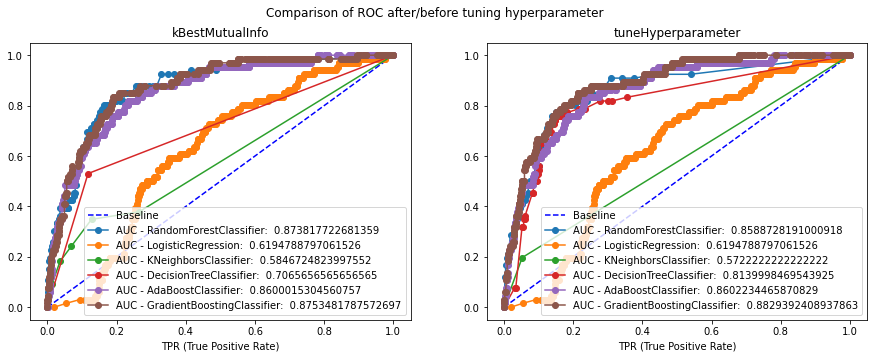

In [52]:
# plot the combined AUC curves - resample basis
plt.figure(figsize=(10, 6))

# plot figure
fig, sub_figs = plt.subplots(1, 2, sharex=False, figsize=(15, 5), dpi=72)
fig.suptitle("Comparison of ROC after/before tuning hyperparameter")

count = 0
for data_name, mds in auc_rocs.items():
    if data_name not in [C_KBESTMUTUALINFO, C_OPT]:
        continue
    sub_figs[count].set_title(data_name)
    # plot the baseline model, AUC of 0.5
    sub_figs[count].plot([0, 1], [0, 1], color="blue", linestyle="--", label="Baseline")

    sub_figs[count].set_xlabel("FPR (False Positive Rate)", size=10)
    sub_figs[count].set_xlabel("TPR (True Positive Rate)", size=10) 
    for i, item in enumerate(mds):
        sub_figs[count].plot(item['fpr'], item['tpr'], "-o", label=f"AUC - {item['model_name']}:  {item['auc']}")
    sub_figs[count].legend()
    count+=1
plt.show()

# Conclusion

The data initially had imbalance of 3.23%. Different sampling techniques were used to resolve the imbalance, from which imblearn-oversampling resulted in highest accuracy of all and hence was used to balance the data. Further, in order to select the best and efficient solution, the classification models were trained using various ways of feature selection. Since MutualInfo and DecistionTree better improved the accuracy, the data set processed by  MutualInfo and DecistionTree was selected. In addition, overfitting condition was checked by comparing different models, and it was found that only RandomForest exhibhited overfitting condition amongst other models. Further, to improve the model performance hyperparameter tuning was performed, which resulted in {feature resample-oversampling, feature selection-MutualInfo, model-K-Nearest-Neighbors, DecisionTree} as the best/optimalsolution.<br>
The reason we selected two models "K-Nearest-Neighbors", "DecisionTree" is because both of the models result in equally high accuracy.


This is our workflow:  [Project Bankruptcy_Workflow]( https://whimsical.com/ZuCpACo7XKv2sndFrSVnp)

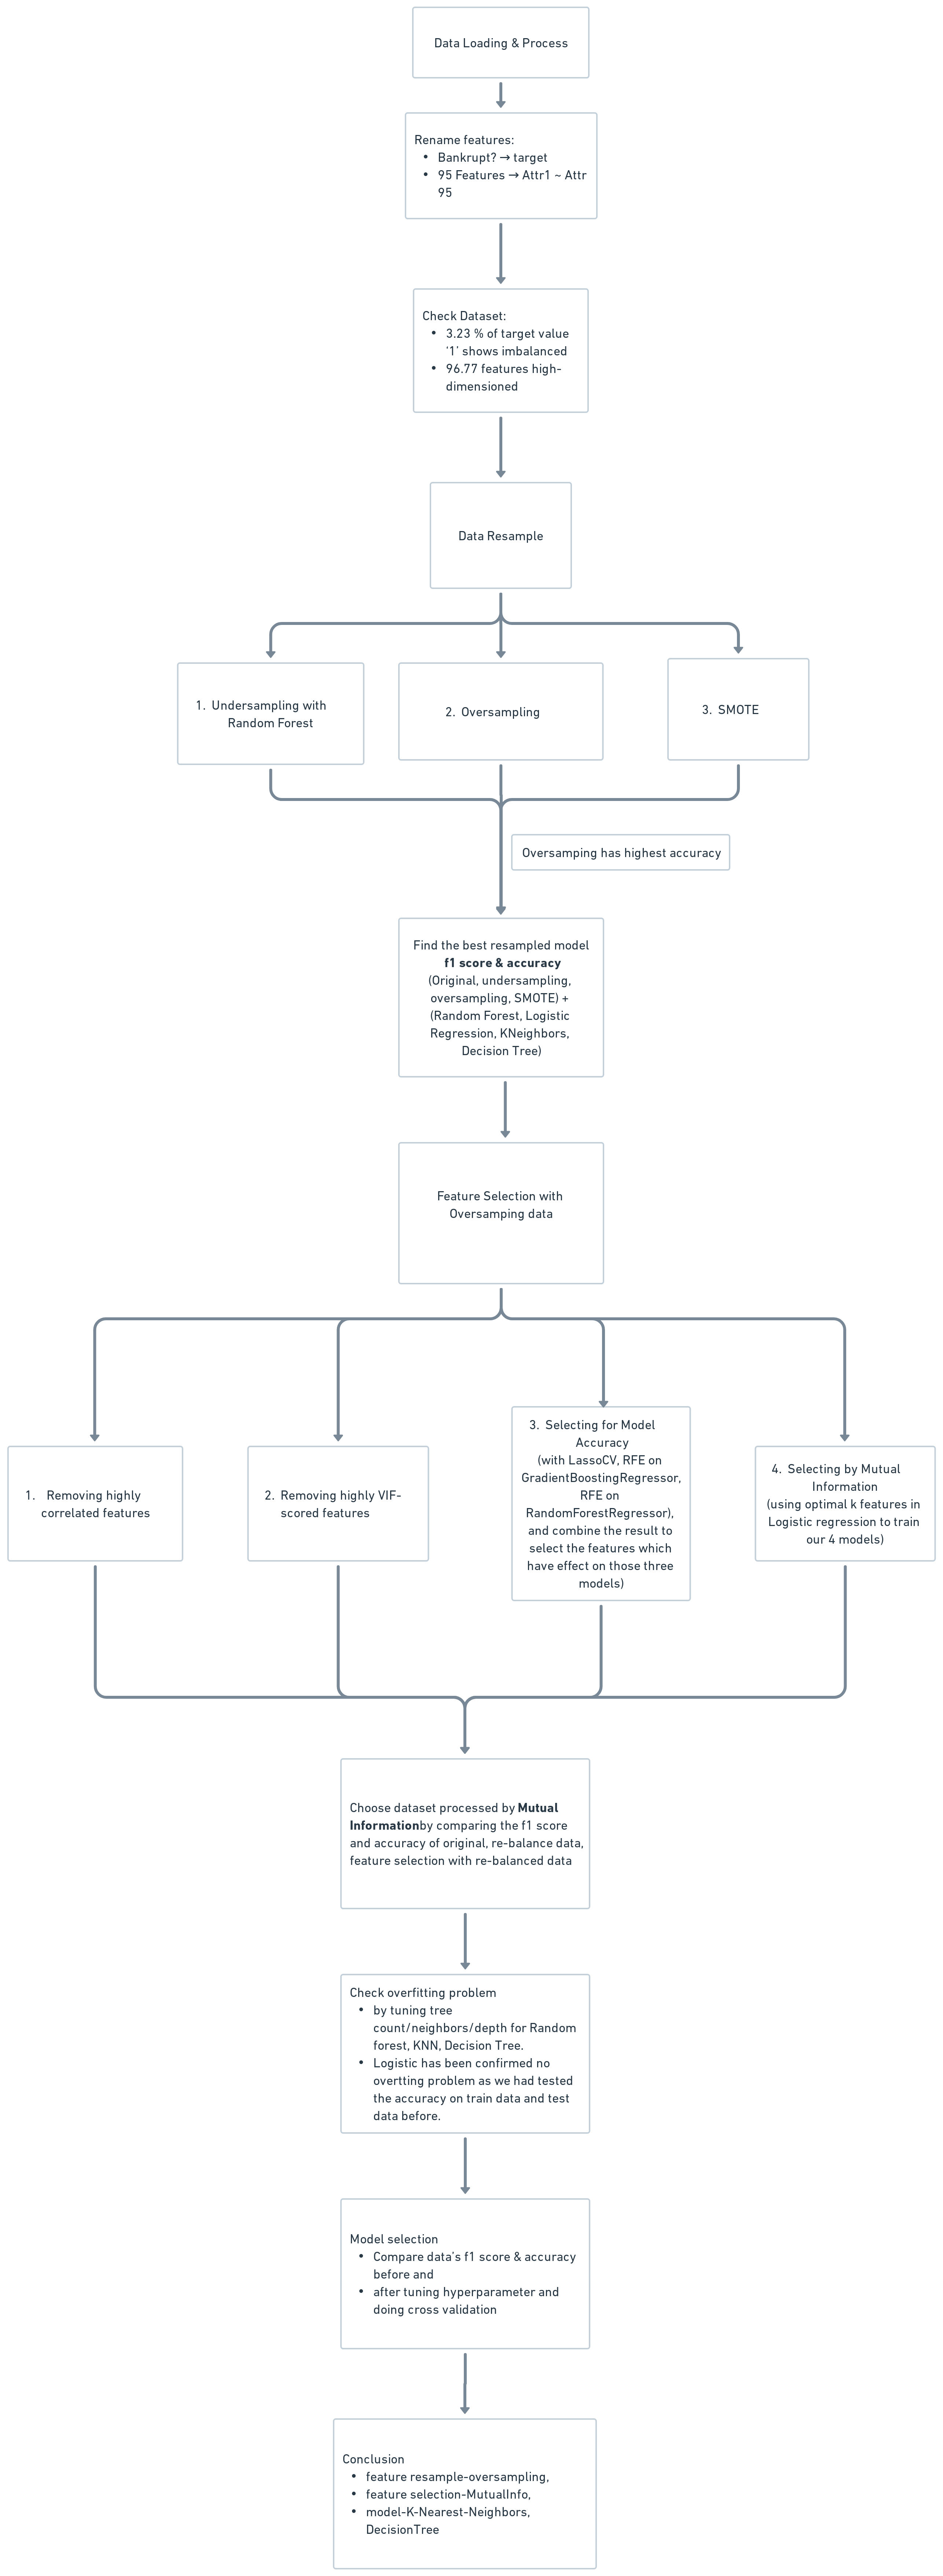